**SPATIAL TRANSCRIPTOMICS ANALYSIS ON OPENST DATA**

Understanding Bioinfomatics Pipeline - BESE294A

Final Project

May 2024

This Jupyter Notebook presents an analysis of human cortical brain organoids, utilizing a cutting-edge spatial transcriptomics technology recently developed known as OPEN-ST (https://www.biorxiv.org/content/10.1101/2023.12.22.572554v1). Open-ST is a sequencing-based revolutionary technique that allows us to visualize and quantify RNA transcripts directly of tissues in 3D. 

**Objective** 

The primary objective of this analysis is to explore the capabilities of OPEN-ST and further compare this technology again other well known spatial transcriptomic technology: Xenium.

**Methodology**

Our approach involves several key steps:

Data Acquisition: We start by acquiring high-resolution spatial transcriptomics data from prepared sections of human cortical brain organoids. 
Quality Control: Initial data processing includes quality control measures to ensure the integrity and reliability of the gene expression data. 
Data Normalization: To account for technical variations, we perform normalization procedures, adjusting the data to facilitate accurate analysis. 
Clustering Analysis: Using advanced clustering algorithms, we identify distinct cell populations based on their gene expression patterns. This analysis is enhanced by dimensionality reduction techniques such as UMAP (Uniform Manifold Approximation and Projection), which provides a visual representation of the cellular clusters. 
Differential Expression Analysis: We conduct differential expression analysis between some of the identified clusters to pinpoint genes that are significantly upregulated or downregulated, helping to define the unique characteristics of each cluster. 

**Packages Used** 

Scanpy: This is the primary Python library used for analyzing single-cell RNA sequencing data. It provides powerful tools for preprocessing, visualization, clustering, and differential expression analysis.OPEN-ST is designed to be analyzed with scanpy.  
Pandas: Employed for data manipulation and for organizing  for downstream analysis.  
Matplotlib and Seaborn: These Python libraries are used for creating visualizations for illustrating the spatial distribution of gene expression.  
NumPy: NumPy used for operations between arrays/matrices in the main object.  
SCTransform: An R-based method, integrated into Python via interfaces, for normalization of single-cell RNA sequencing data. SCTransform employs a variance stabilizing transformation that is particularly effective in adjusting for technical noise and enhancing the detection of true biological signals.

In [163]:
#loading modules 
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import SCTransform
import numpy as np

**Data Acquisition and exploration**

We start by loading the data from one sample and exploring the structure of the object, which consist in a h5ad file with transcriptomic information per segmented cell, with spatial coordinates aligned to the staining image. Note that all the preprocessing steps required to produce this h5ad where perfomed by colaborators of Prof. Adamo's lab, in Max-Delbrück-Centrum for Molecular Medicine in the Helmholtz Association (MDC). However is possible to replicate all the preprocessing steps by following the step by step protocol avaialble at: https://rajewsky-lab.github.io/openst/latest/introduction/

In [243]:
#Loading one dataset, as an example
adata = sc.read_h5ad("./data/88_1_157A_49XXXXY_hexagon_puck_collection.h5ad")
#lets see how adata is structured
adata

AnnData object with n_obs × n_vars = 66668 × 28931
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id'
    uns: 'fc_010_L3_tile_2452', 'fc_010_L3_tile_2453', 'fc_010_L3_tile_2552', 'fc_010_L3_tile_2553', 'fc_010_L3_tile_2652', 'fc_010_L3_tile_2653'
    obsm: 'spatial'

From the previous run we got an object with the following structure: 

**obs - the spatial metadata:** Short for "observations," the .obs attribute is a pandas DataFrame where each row corresponds to a cell and columns store cell-specific annotations. These annotations can include anything from cell types, experimental conditions, technical covariates, to clustering assignments. obs DataFrame is crucial in spatial transcriptomics for storing metadata related to spatial coordinates, spot identifiers, and possibly cluster identities or cell types assigned to each spatial spot. This information is essential for analyzing spatial patterns of gene expression.

**uns - the spatial annotations:** Short for "unstructured," this attribute is a dictionary to store unstructured data that doesn’t fit into the structured form of the rest of the object. The .uns dictionary is often used to store additional information that is critical for spatial analyses, such as the layout of the tissue sections, spatial coordinates of each spot, and images of the tissue sections. This information can be crucial for visualizing gene expression data in the context of the tissue's physical structure.

**obsm - the spatial embeddings and coordinates:** These are dictionaries of DataFrames and serve to store multi-dimensional annotations for observations (cells) and variables (genes), respectively. For example, you could store the PCA coordinates of the cells in .obsm.

**Calculating QC metrics of the Samples**

Now, we can show different plots to assess the number of unique transcripts (UMIs), genes, percentage of mitochondrial transcripts per segmented cell, as a quick way of assessing the quality of the dataset. This will help to decide on filtering thresholds, to remove potential low quality cells (i.e., due to poor sequencing coverage, or wrong segmentation of background as cells).

In [2]:

def process_and_plot_qc_metrics(adata, sample):
    """
    Calculate QC metrics, generate QC plots, and save the updated AnnData object.
    
    Parameters:
    - adata: name of the AnnData object to process.
    - sample : sample name to save the data
    """
    #Loading the data
    adata = sc.read_h5ad(adata)
    #removing cells with zero counts
    adata = adata[adata.obs['total_counts'] > 0]


    #calculating quality control (QC) metrics 
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    #Adding a new column, named "Mito", to the adata.var DataFrame. indicating whether each gene is mitochondrial genes.
    adata.var["Mito"] = adata.var_names.str.startswith("MT-")
    # The function recalculates QC metrics, this time specifically considering the mitochondrial genes 
    sc.pp.calculate_qc_metrics(adata, qc_vars=["Mito"], inplace=True)
    
    # Setup the figure for plotting violin plots
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    # Plotting Total Counts
    sns.violinplot(x=None, y=adata.obs["total_counts"], ax=axs[0])
    axs[0].set_title('Total Counts')
    # Plotting Percentage of Mitochondrial Counts
    sns.violinplot(x=None, y=adata.obs["pct_counts_mt"], ax=axs[1])
    axs[1].set_title('Percentage of Mitochondrial Counts')
    # Plotting Number of Genes Detected
    sns.violinplot(x=None, y=adata.obs["n_genes_by_counts"], ax=axs[2])
    axs[2].set_title('Number of Genes Detected')
    # Adjust layout and add super title
    plt.tight_layout()
    fig.suptitle(f"QC Metrics Distribution sample {sample}", fontsize=16, y=1.05)
    # Save the figure
    plt.savefig(f"./figures/QC_violin_{sample}_v2.png", dpi=300)
    
    #plotting histograms

    figh, axsh = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(adata.obs["total_counts"], kde=False, bins=60, ax=axsh[0])
    axsh[0].set_title('Counts Distribution')  # Adding a title for the first plot
    #histogram of the percentage of mitochondrial genes
    sns.histplot(adata.obs["pct_counts_mt"], kde=False, bins=60, ax=axsh[1])
    axsh[1].set_title('Percentage of Mitochondrial Counts') 
    #histogram of number of genes detected by counts
    sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axsh[2])
    axsh[2].set_title('Number of Genes Detected')  # Adding a title for the third plot
    #add title to the plot 
    figh.suptitle(f"QC Metrics Distribution sample {sample}", fontsize=16, y=1.05)
    #saving the figure
    plt.savefig(f"./figures/QC_hist_{sample}_v2.png", dpi=300)  # Save as a PNG file with high resolution

    # Save the AnnData object
    adata_save_path = f"./analyzed_data/{sample}_with_qc_v2.h5ad"
    adata.write(adata_save_path)
    
    print(f"QC metrics calculated, plots saved and AnnData object saved to '{adata_save_path}'.")

/home/cardonky/miniconda3/envs/spatial/lib/python3.12/site-packages/scanpy/preprocessing/_qc.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


QC metrics calculated, plots saved and AnnData object saved to './analyzed_data/88_3_807G_46XY_with_qc_v2.h5ad'.


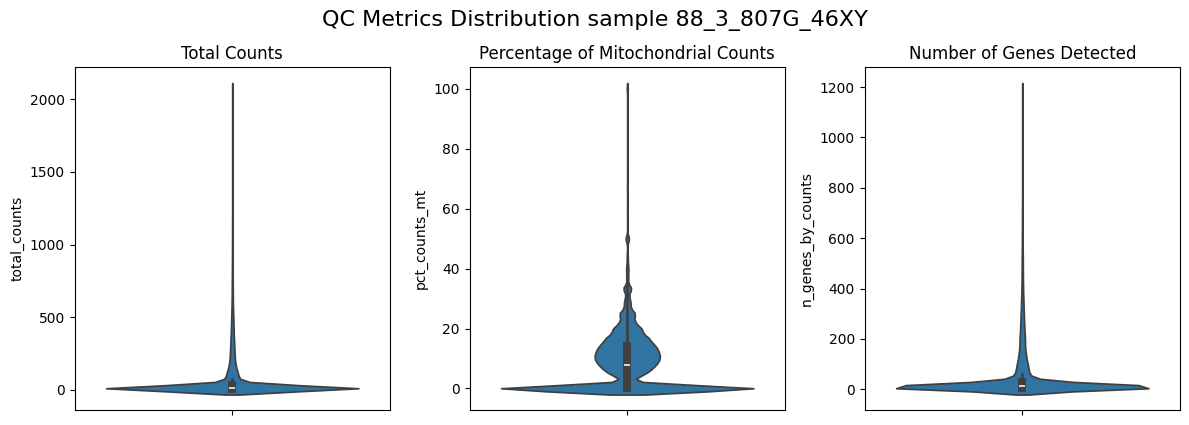

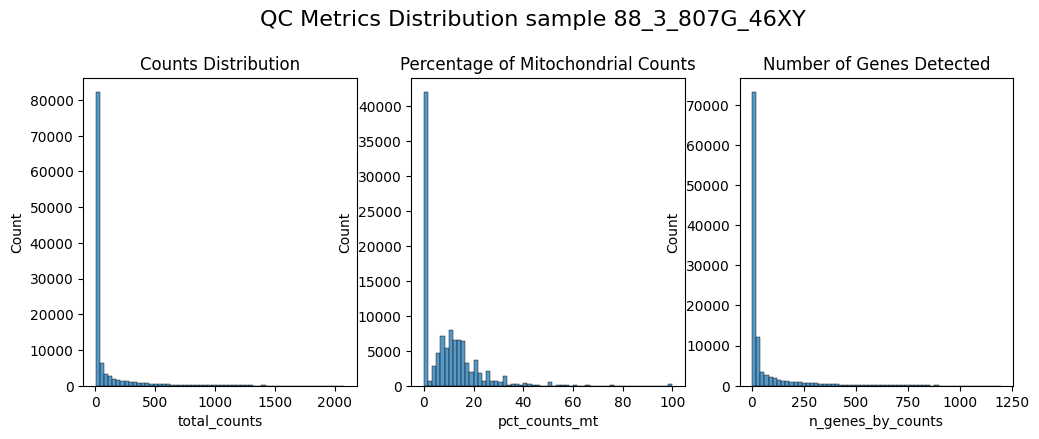

In [5]:
adata3 = "./data/88_3_807G_46XY_hexagon_puck_collection.h5ad"
name3 = "88_3_807G_46XY"
process_and_plot_qc_metrics(adata3,name3)

/home/cardonky/miniconda3/envs/spatial/lib/python3.12/site-packages/scanpy/preprocessing/_qc.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


QC metrics calculated, plots saved and AnnData object saved to './analyzed_data/88_4B_807G_46XY_with_qc_v2.h5ad'.


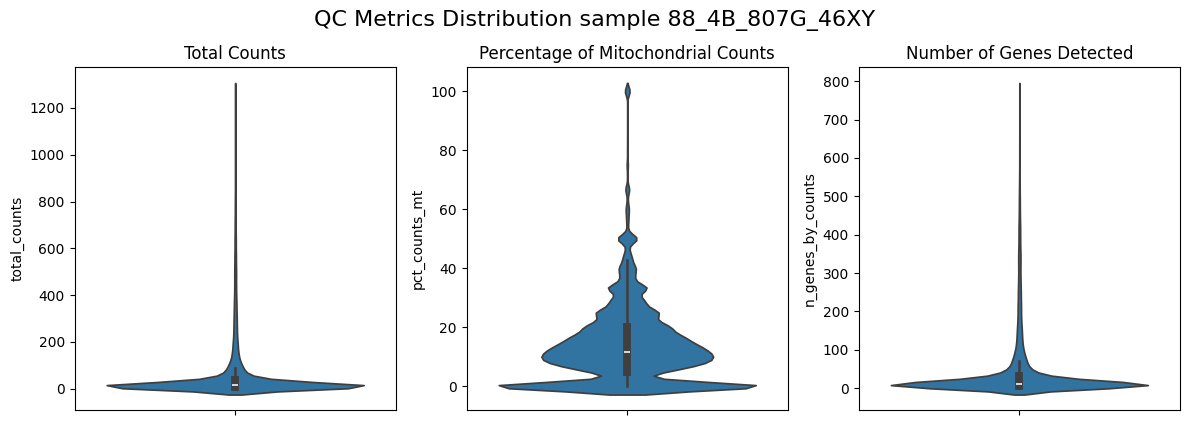

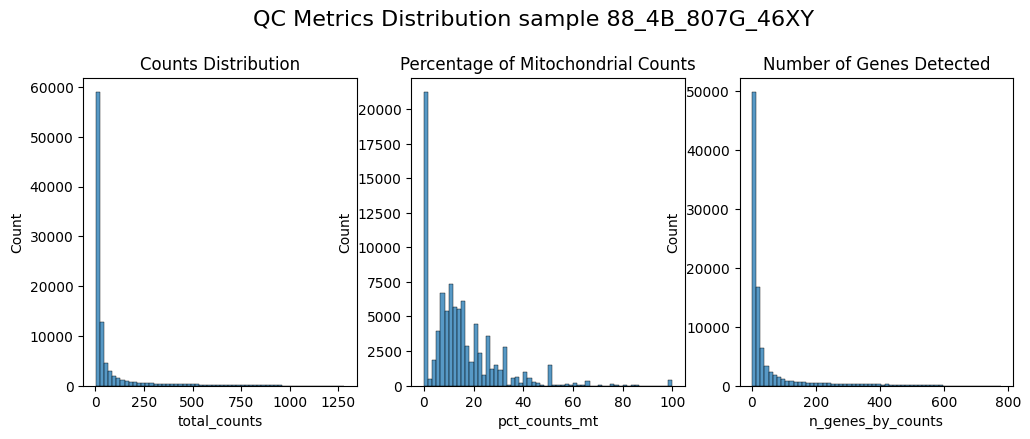

In [6]:
adata4 = "./data/88_4B_807G_46XY_hexagon_puck_collection.h5ad"
name4 = "88_4B_807G_46XY"
process_and_plot_qc_metrics(adata4,name4)

when we calculate the QC our object will change a little. For observations (cells): It calculates metrics such as the total number of molecules (counts) detected, the total number of genes detected, and others. These metrics are then added to adata.obs, enhancing it with new columns that reflect these QC metrics.
For variables (genes): Similar metrics are calculated, like the number of cells a gene is detected in, and these metrics are added to adata.var.
now we have a new element in our structure. The .var attribute is Short for "variables" is another pandas DataFrame where each row corresponds to a gene and columns store gene-specific information. This can include gene names, genomic coordinates, and any other gene-related metadata.

**Filtering based on QC**

For performing filtering of the datasets we used some thresholds based on the original distribution of the data, the filtering was setted as: 
*Counts:* A common threshold for Counts is to filter out cells with extremely low counts, as they might be empty droplets or cells with very poor RNA capture. We set a lower threshold at 10th percentile of the counts distribution.  
*Genes:* The number of detected genes per cell can be indicative of cell health and capture efficiency. Cells with very few genes detected can be considered low quality. We set a minimum threshold to exclude cells below the 10th percentile of the gene count distribution.   
*Percentage of Mitochondrial Transcripts:* A high percentage of mitochondrial transcripts often indicates cell stress or cell death. In our case mitochondrial transcripts over percentile 90 are excluded from further analysis. This threshold was setted considering that brain organoids resemble embrionic brain development where mitochondrial content is lower than other tissues like hearth or muscule but still high enought for a tissue in developmental process and with a metabolism very active. 

In [25]:

def filter_cells_by_percentile(file_path, output_prefix):
    """
    Filters cells based on percentile thresholds for total counts, number of genes, and mitochondrial content.

    Parameters:
    file_path (string): path to Annotated data matrix with QC annotations.
    output_prefix (string): name of the sample

    Returns:
    AnnData: Filtered annotated data matrix.
    Plots: qc Plots after filtering 
    """
    # Load the data
    adata = sc.read_h5ad(file_path)
    
    # Calculate percentiles for filtering
    percentile_10_umi = np.percentile(adata.obs['total_counts'], 10)
    percentile_10_genes = np.percentile(adata.obs['n_genes_by_counts'], 10)
    percentile_90_mt = np.percentile(adata.obs['pct_counts_mt'], 90)
    
    # Filter the data
    adata_filtered = adata[
        (adata.obs['total_counts'] > percentile_10_umi) &
        (adata.obs['n_genes_by_counts'] > percentile_10_genes) &
        (adata.obs['pct_counts_mt'] < percentile_90_mt)
    ]
    
    # Plot histograms for QC metrics before and after filtering
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # 3 columns for metrics
    
    # After filtering
    sns.histplot(adata_filtered.obs["total_counts"], kde=False, bins=60, ax=axs[0])
    axs[0].set_title('Filt. Counts Distribution')
    sns.histplot(adata_filtered.obs["pct_counts_mt"], kde=False, bins=60, ax=axs[1])
    axs[1].set_title('Filt. Percentage of Mitochondrial Counts')
    sns.histplot(adata_filtered.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    axs[2].set_title('Filt. Number of Genes Detected')
    #add title to the plot 
    fig.suptitle(f"QC Metrics Distribution sample {output_prefix} (filtered)", fontsize=16, y=1.05)
    #save plot
    plt.savefig(f'./figures/QC_hist_{output_prefix}_filtered.png', dpi=300)  # Save the qc plot after filtering
    
    # Save the AnnData object
    adata_save_path = f"./analyzed_data/{output_prefix}_filtered.h5ad"
    adata_filtered.write(adata_save_path)

    print("Filtering complete. Number of cells retained:", adata_filtered.shape[0])

Filtering complete. Number of cells retained: 43990


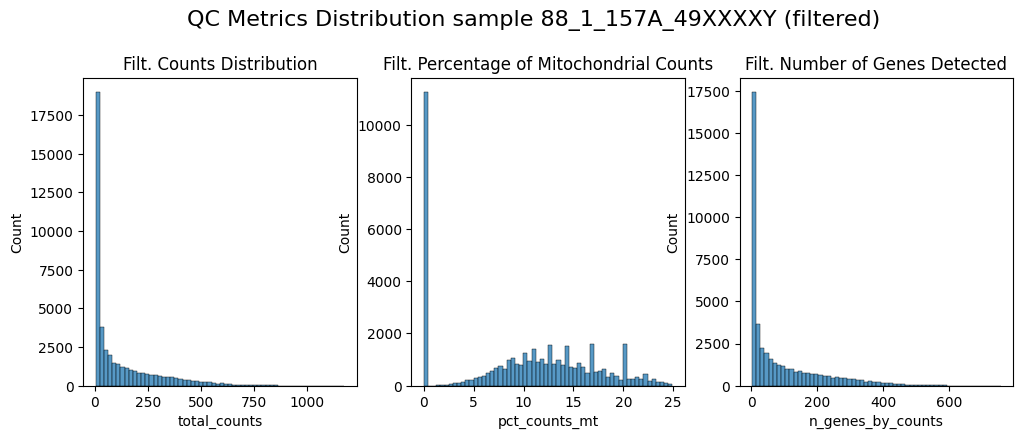

In [26]:
adata1 = "./analyzed_data/88_1_157A_49XXXXY_with_qc_v2.h5ad"
name1 = "88_1_157A_49XXXXY"
filter_cells_by_percentile(adata1,name1)

Filtering complete. Number of cells retained: 93453


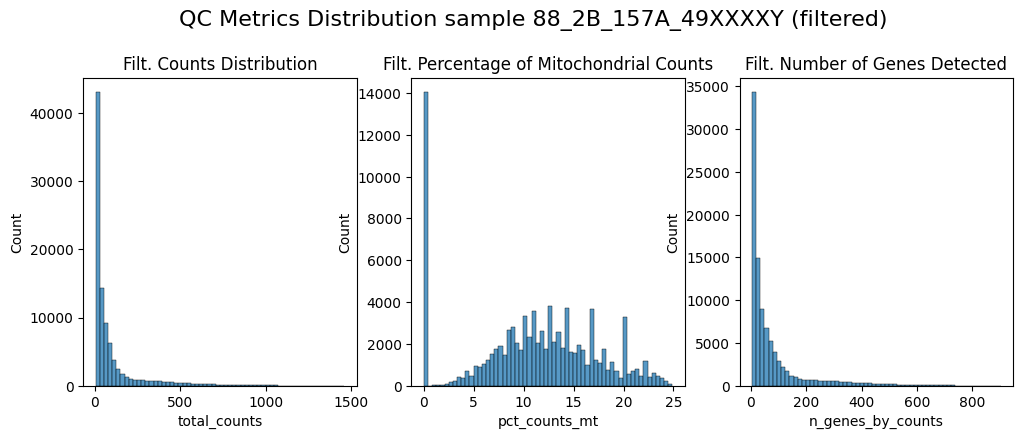

In [27]:
adata2 = "./analyzed_data/88_2B_157A_49XXXXY_with_qc_v2.h5ad"
name2 = "88_2B_157A_49XXXXY"
filter_cells_by_percentile(adata2,name2)

Filtering complete. Number of cells retained: 86714


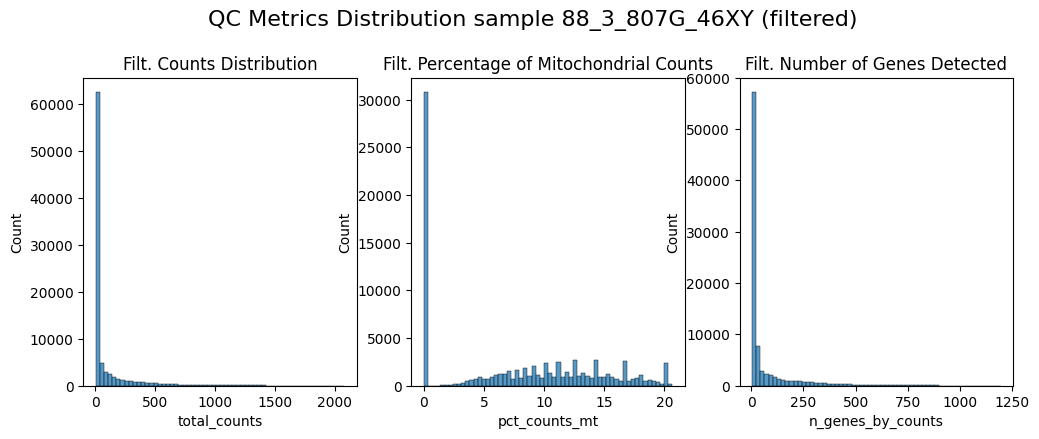

In [28]:
adata3 = "./analyzed_data/88_3_807G_46XY_with_qc_v2.h5ad"
name3 = "88_3_807G_46XY"
filter_cells_by_percentile(adata3,name3)

Filtering complete. Number of cells retained: 73879


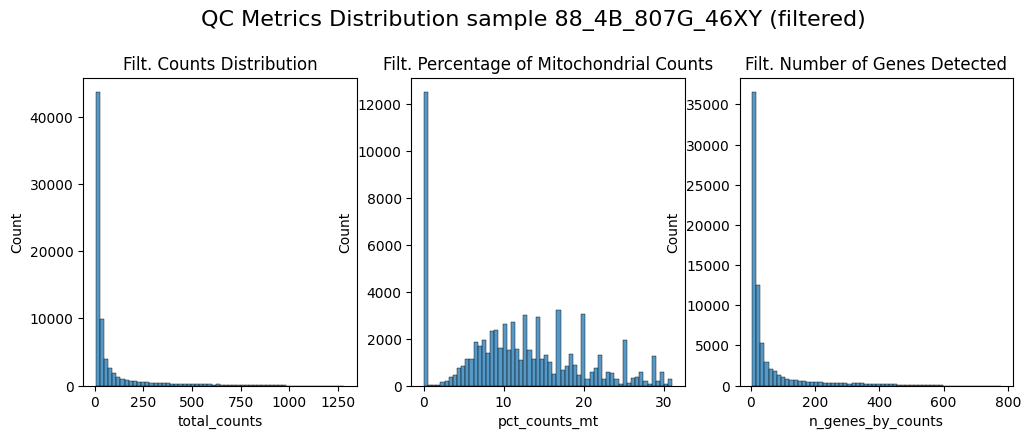

In [29]:
adata4 = "./analyzed_data/88_4B_807G_46XY_with_qc_v2.h5ad"
name4 = "88_4B_807G_46XY"
filter_cells_by_percentile(adata4,name4)

**Normalization**

Normalization is necessary, for example to account for the differences in depth per cell and remove potential biases, or to estabilize the variance of genes and remove their dependency on the counts.

It is still under study, but normalization strategies for single-cell are most likely not well suited for this kind of high-resolution, single-cell spatial data. Especially, since counts have an additional source of (spatial) coviariance that does not exist in single-cell datasets. Therefore, it is possible that the covariance and errors from spatial components are propagated throughout the analysis pipeline, and some signal or significant results are just noise from the spatial autocorrelations. Anyway,  for this exercise we are using two  common normalization methods whidely used: the classical log-normalization with pseudocounts and the SCTransform methods. This is just a way to explore the data but in a real research context the normalization step must be performed and selected very carefully. 

**The classical normalization follow by Logaritmic transformation**

The function sc.pp.normalize_total() from Scanpy will normalize the gene expression measurements in each cell, so that the total counts per cell sum to the same value, typically 1e4. This normalization accounts for differences in sequencing depth among cells, which is crucial for comparing transcriptional profiles across cells. Following normalization, applying sc.pp.log1p(), which computes the natural logarithm of the expression values plus one (log(x+1)), is a common practice. This transformation helps in stabilizing the variance across genes, making the data more amenable to various analytical techniques that assume normally distributed data.


In [34]:

def normalize_log1p(adata_path, sample):
    """
    This function loads filtered data, normalizes it using the canonical log transformation,
    and then saves the normalized data to a new file.
    
    Parameters:
    adata_path (str): The file path to the filtered AnnData object.
    sample (str): The sample name to identify the new normalized AnnData object.
    """
    # Loading the data filtered
    adata_filtered = sc.read_h5ad(adata_path)
    
    # Normalization with the canonical method - log transformation
    sc.pp.normalize_total(adata_filtered, inplace=True)
    sc.pp.log1p(adata_filtered)
    
    # Saving the object with the normalization
    adata_save_path = f"./analyzed_data/{sample}_normalized.h5ad"
    adata_filtered.write(adata_save_path)

    print("Normalization complete. Number of cells retained:", adata_filtered.shape[0])
    print(f"Normalized data saved to {adata_save_path}")

In [36]:
adata2 = "./analyzed_data/88_2B_157A_49XXXXY_filtered.h5ad"
name2 = "88_2B_157A_49XXXXY"
normalize_log1p(adata2,name2)

Normalization complete. Number of cells retained: 93453
Normalized data saved to ./analyzed_data/88_2B_157A_49XXXXY_normalized.h5ad


In [37]:
adata3 = "./analyzed_data/88_3_807G_46XY_filtered.h5ad"
name3 = "88_3_807G_46XY"
normalize_log1p(adata3,name3)

Normalization complete. Number of cells retained: 86714
Normalized data saved to ./analyzed_data/88_3_807G_46XY_normalized.h5ad


In [38]:
adata4 = "./analyzed_data/88_4B_807G_46XY_filtered.h5ad"
name4 = "88_4B_807G_46XY"
normalize_log1p(adata4,name4)

Normalization complete. Number of cells retained: 73879
Normalized data saved to ./analyzed_data/88_4B_807G_46XY_normalized.h5ad


In [39]:
adata1 = "./analyzed_data/88_1_157A_49XXXXY_filtered.h5ad"
name1 = "88_1_157A_49XXXXY"
normalize_log1p(adata1,name1)

Normalization complete. Number of cells retained: 43990
Normalized data saved to ./analyzed_data/88_1_157A_49XXXXY_normalized.h5ad


**Normalization with SCTransform**

SCTransform is a normalization method popularized by the Seurat package in R, known for its ability to stabilize variance across features, improve clustering outcomes, and enhance the detection of differentially expressed genes. It utilizes regularized negative binomial regression to model gene expression data.SCTransform is available as a Python package that mimics the functionality of Seurat's SCTransform. 

When using SCTransform we should be careful with the parameter settings, choosing the right values depends largely on your specific dataset and your analysis goals. Not all parameters may need to be explicitly set, as defaults may often work well under typical scenarios. However, in our case we should select carefully the thresholds for some parameters as follows. 
1. min_cells. Purpose: Determines the minimum number of cells a gene must be expressed in to be included in the analysis. 
2. n_genes Purpose: Specifies the number of highly variable genes to select based on their expression variability across cells. 

As for the filtering we will set this values based on the data distribution. 

In [40]:
# to define the parameters for the SCTransform normalization I will check first the distribution of the values on my dataset
def define_parameters(file_path):

    #open the filtered object 
    adataf = sc.read_h5ad(file_path)

    #To define value for parameter n_genes
    mean_genes_per_spot = adataf.obs['n_genes_by_counts'].mean()
    print("Mean number of genes detected per spot:", mean_genes_per_spot)
    median_genes_per_spot = adataf.obs['n_genes_by_counts'].median()
    print("Median number of genes detected per spot:", median_genes_per_spot)

In [44]:
define_parameters("./analyzed_data/88_1_157A_49XXXXY_filtered.h5ad")

Mean number of genes detected per spot: 87.14773812230052
Median number of genes detected per spot: 33.0


In [41]:
define_parameters("./analyzed_data/88_2B_157A_49XXXXY_filtered.h5ad")

Mean number of genes detected per spot: 71.12431917648443
Median number of genes detected per spot: 30.0


In [42]:
define_parameters("./analyzed_data/88_3_807G_46XY_filtered.h5ad")

Mean number of genes detected per spot: 62.64656226214913
Median number of genes detected per spot: 15.0


In [43]:
define_parameters("./analyzed_data/88_4B_807G_46XY_filtered.h5ad")

Mean number of genes detected per spot: 54.96689180958053
Median number of genes detected per spot: 17.0


Based on the previous results we should use the median value since apparently there are outliers affecting the mean on all samples. The next step is to determine the minimun number of cells by performing a cumulative plot of the counts distribution to visualize/define the cutoff in the number of cells. 
This approach not only ensures that the min_cells setting is data-driven but also helps in maintaining the integrity and relevance of the downstream analyses by focusing on genes that are more consistently expressed across the dataset.

In [7]:

def plot_cumulative_distribution(adata_path, sample):
    """
    Plots the cumulative distribution of gene expression across cells.
    
    Parameters:
    adata_path (str): The file path to the filtered AnnData object.
    sample (str): The sample name to identify the figure.

    """
    adata_filtered = sc.read_h5ad(adata_path)

    # Calculate the number of genes expressed in X number of cells
    gene_counts = np.bincount(adata_filtered.var['n_cells_by_counts'].astype(int))
    cells_index = np.arange(len(gene_counts))

    plt.figure(figsize=(10, 6))
    #plt.bar(cells_index, gene_counts, color='skyblue')
    plt.title(f'Genes Expressed per Cells - {sample}', fontsize=16)
    plt.xlabel('Number of Cells')
    plt.ylabel('Number of Genes')

    # Adding a cumulative line plot
    cumulative_genes = np.cumsum(gene_counts) / np.sum(gene_counts)
    plt.twinx()  # Create a second y-axis
    plt.plot(cells_index, cumulative_genes, color='orange', label='Cumulative Distribution')
    plt.ylabel('Cumulative Prop. of Genes')
    plt.xlim(0, 200) #zoom in to better visualize 

    plt.legend(loc='upper right')
    plt.show()
    #save plot
    plt.savefig(f'./figures/cum_plot_{sample}.png', dpi=300)  # Save as a PNG file with high resolution



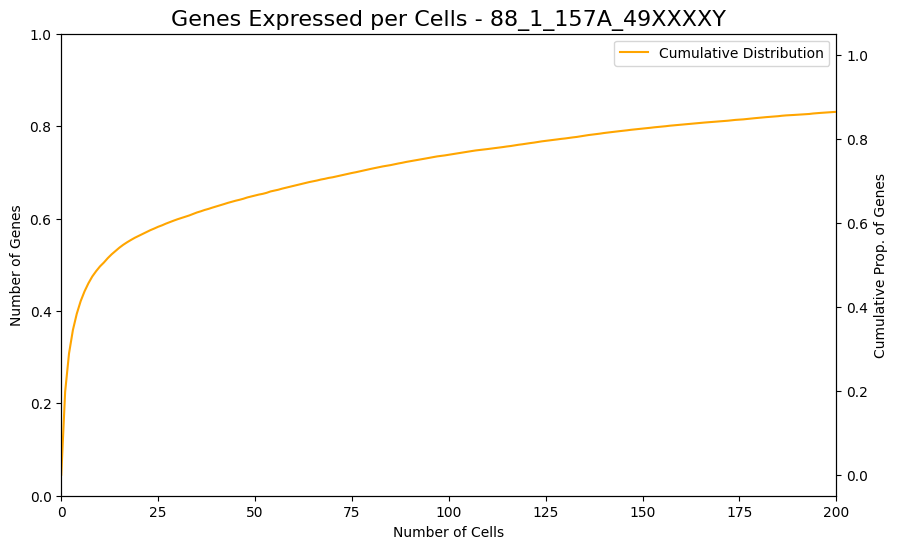

<Figure size 640x480 with 0 Axes>

In [8]:
adata1 = "./analyzed_data/88_1_157A_49XXXXY_filtered.h5ad"
name1 = "88_1_157A_49XXXXY"
plot_cumulative_distribution(adata1,name1)

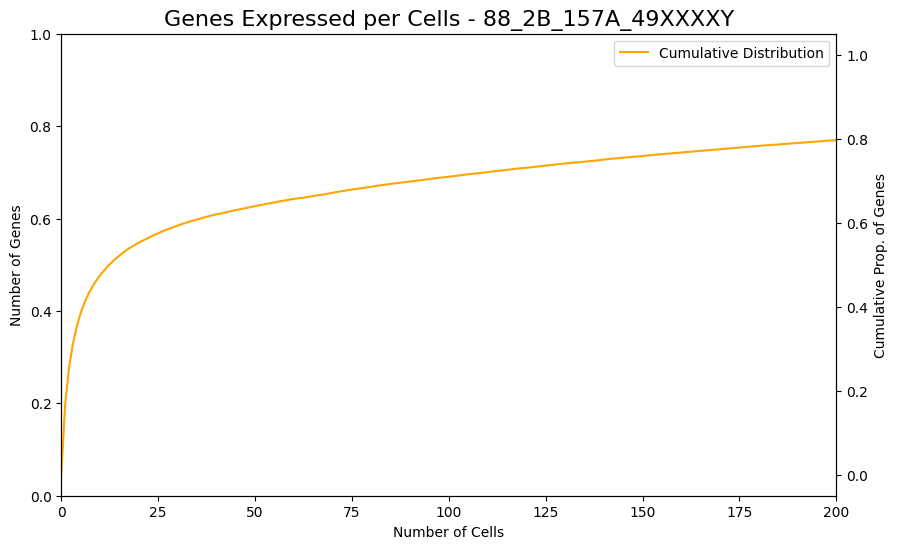

<Figure size 640x480 with 0 Axes>

In [9]:
adata2 = "./analyzed_data/88_2B_157A_49XXXXY_filtered.h5ad"
name2 = "88_2B_157A_49XXXXY"
plot_cumulative_distribution(adata2,name2)

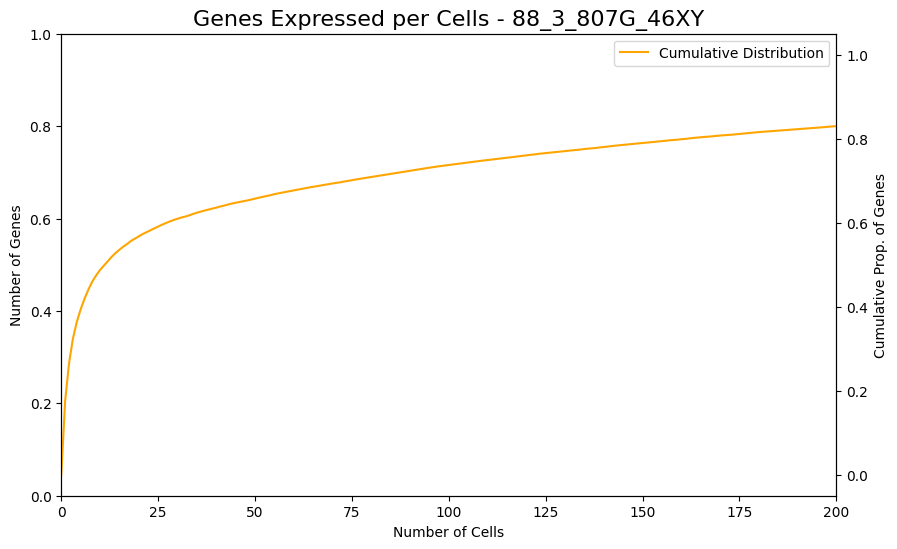

<Figure size 640x480 with 0 Axes>

In [10]:
adata3 = "./analyzed_data/88_3_807G_46XY_filtered.h5ad"
name3 = "88_3_807G_46XY"
plot_cumulative_distribution(adata3,name3)

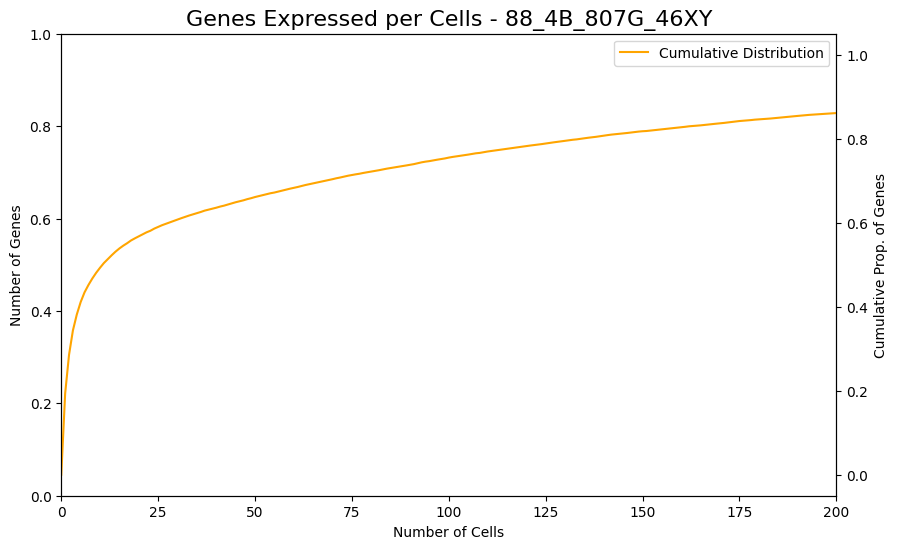

<Figure size 640x480 with 0 Axes>

In [11]:
adata4 = "./analyzed_data/88_4B_807G_46XY_filtered.h5ad"
name4 = "88_4B_807G_46XY"
plot_cumulative_distribution(adata4,name4)

Based on the cumulatives distribution plots, the curves seems to start leveling off significantly around 25 cells, but it's still gradually increasing, varing from one to another sample. This suggests that setting min_cells at 25 could be a reasonable choice, to include genes that are present in a moderate number of cells while filtering out those that are present in very few cells and may represent noise. 

In [29]:
#Performing SCTransform normalization 

def apply_sctransform(adata, sample, min_cells):
    """
    Apply SCTransform normalization to an AnnData object with specified parameters.
    
    Parameters:
    adata_path (str): The file path to the filtered AnnData object.
    sample (str): The sample name to identify the figure
    min_cells (int): Minimum number of cells for genes to be included in the analysis.

    """
    adata = sc.read_h5ad(adata)
    median_genes_per_spot = adata.obs['n_genes_by_counts'].median()
    n_genes_chosen = int(median_genes_per_spot)
  
    # Apply SCTransform normalization
    normalized_adata = SCTransform.SCTransform(
        adata,
        min_cells=min_cells,
        gmean_eps=1,
        n_genes=n_genes_chosen,
        bin_size=30,
        bw_adjust=3,
        inplace=False
    )
    
    normalized_adata.write(f'./analyzed_data/{sample}_sctransform.h5ad')
    print(f"Normalized data saved to ./analyzed_data/{sample}_sctransform.h5ad")
    return normalized_adata


In [28]:
adata1 = "./analyzed_data/88_1_157A_49XXXXY_filtered.h5ad"
name1 = "88_1_157A_49XXXXY"
apply_sctransform(adata1,name1,25)

Normalized data saved to ./analyzed_data/88_1_157A_49XXXXY_sctransform.h5ad
Normalization complete. Number of cells retained: 43990


AnnData object with n_obs × n_vars = 43990 × 12114
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'

In [33]:
adata2 = "./analyzed_data/88_2B_157A_49XXXXY_filtered.h5ad"
name2 = "88_2B_157A_49XXXXY"
apply_sctransform(adata2,name2,25)

/Users/cardonky/miniconda3/envs/spatial_local/lib/python3.12/site-packages/SCTransform.py:131: RuntimeWarning: divide by zero encountered in log10
  log_umi = np.log10(umi)
/Users/cardonky/miniconda3/envs/spatial_local/lib/python3.12/site-packages/SCTransform.py:135: RuntimeWarning: divide by zero encountered in log10
  log_gene = np.log10(gene)
/Users/cardonky/miniconda3/envs/spatial_local/lib/python3.12/site-packages/SCTransform.py:136: RuntimeWarning: invalid value encountered in divide
  umi_per_gene = umi / gene


ValueError: array must not contain infs or NaNs

In [31]:
adata3 = "./analyzed_data/88_3_807G_46XY_filtered.h5ad"
name3 = "88_3_807G_46XY"
apply_sctransform(adata3,name3,25)

Normalized data saved to ./analyzed_data/88_3_807G_46XY_sctransform.h5ad


AnnData object with n_obs × n_vars = 86714 × 13987
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'

In [32]:
adata4 = "./analyzed_data/88_4B_807G_46XY_filtered.h5ad"
name4 = "88_4B_807G_46XY"
apply_sctransform(adata4,name4,25)

Normalized data saved to ./analyzed_data/88_4B_807G_46XY_sctransform.h5ad


AnnData object with n_obs × n_vars = 73879 × 12836
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'

**Comparing the normalization Methods** 

To select mong different avaialble normalization methods, is worth to calculate the gene variance againt the mean expression for no-normlaized data and normalized data using different methods. This approach let us visually inspect the effect of different normalization methods on the expression variability in our data. 

In [62]:
def plot_variance_vs_mean(adata, mean_column, variance_column, ax, title, 
                          color='gray', label=None, data_location=['var', 'obs']):
    """
    Plot variance vs. mean for an AnnData object using specified columns, from either .var or .obs.
    
    Parameters:
    - adata: AnnData object containing the data.
    - mean_column: str, the column name to use for mean values.
    - variance_column: str, the column name to use for variance values.
    - ax: matplotlib axes object for plotting.
    - title: str, title for the plot.
    - color: str, color of the plot points.
    - label: str, label for the legend.
    - data_location: str, 'var' or 'obs' to specify where the mean and variance columns are located.
    """
    if data_location == 'var':
        data_frame = adata.var
    elif data_location == 'obs':
        data_frame = adata.obs
    else:
        print("Invalid data location specified. Use 'var' or 'obs'.")
        return

    if mean_column in data_frame.columns and variance_column in data_frame.columns:
        means = data_frame[mean_column]
        variances = data_frame[variance_column]

        # Scatter plot
        ax.scatter(means, variances, color=color, alpha=0.5, label=label)
        ax.set_title(title)
        ax.set_xlabel('Average Expression')
        ax.set_ylabel('Gene Variance')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True)
        if label:
            ax.legend()

    else:
        print(f"The required columns '{mean_column}' or '{variance_column}' are not found in the AnnData object.")

In [132]:
#First sample: 88_1_157A_49XXXXY
adata = sc.read_h5ad('./analyzed_data/88_1_157A_49XXXXY_filtered.h5ad')  # Load your original data
norm_adata1 = sc.read_h5ad('./analyzed_data/88_1_157A_49XXXXY_normalized.h5ad')  # normalized data - log1p
norm_adata2 = sc.read_h5ad('./analyzed_data/88_1_157A_49XXXXY_sctransform.h5ad')  # Load your second normalized data

In [133]:
norm_adata1

AnnData object with n_obs × n_vars = 43990 × 28931
    obs: 'x_pos', 'y_pos', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_reads', 'reads_per_counts', 'n_joined', 'exact_entropy', 'theoretical_entropy', 'exact_compression', 'theoretical_compression', 'puck_id', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_Mito', 'log1p_total_counts_Mito', 'pct_counts_Mito'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'Mito'
    uns: 'fc_010_L3_tile_2452', 'fc_010_L3_tile_2453', 'fc_010_L3_tile_2552', 'fc_010_L3_tile_2553', 'fc_010_L3_tile_2652', 'fc_010_L3_tile_2653', 'log1p'
    obsm: 'spatial'

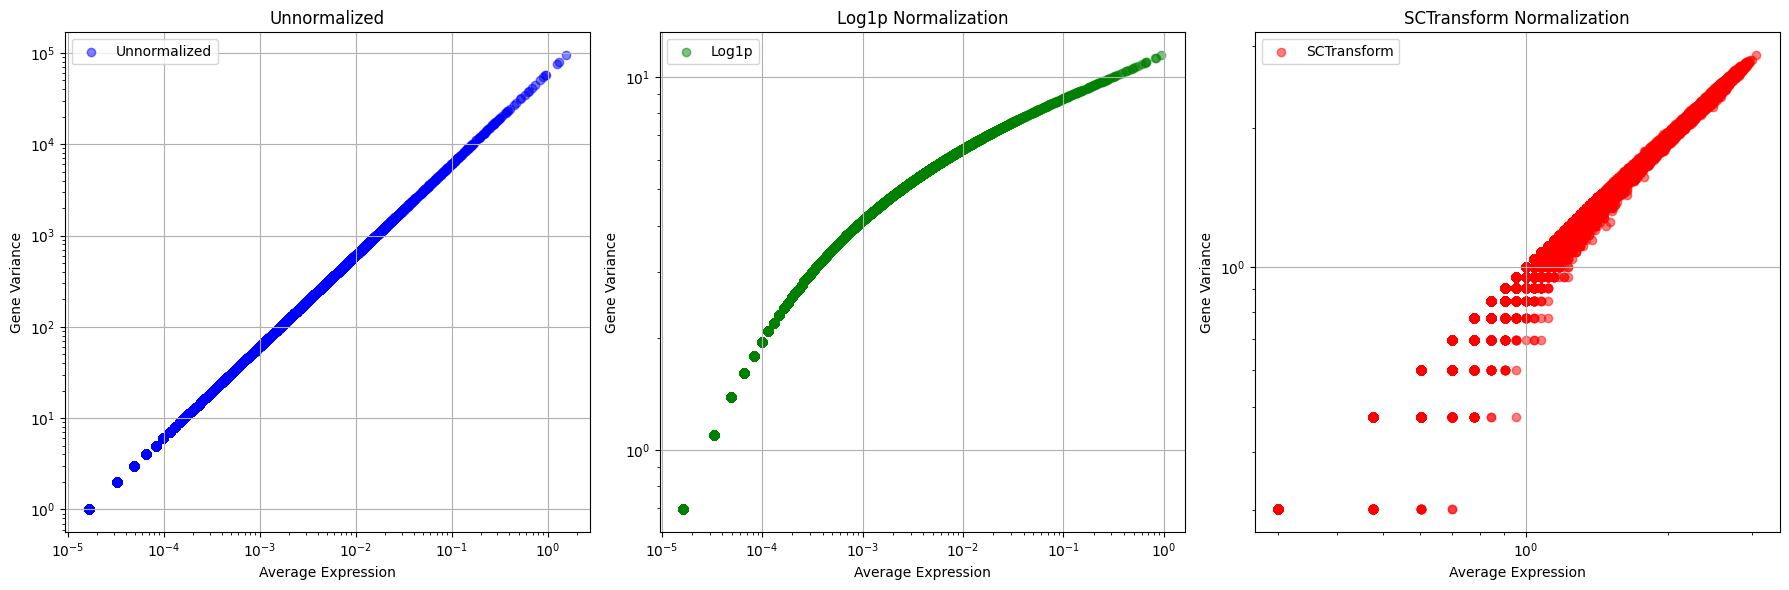

In [63]:
# setup
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# calls 
plot_variance_vs_mean(adata, 'mean_counts', 'total_counts', axs[0], 'Unnormalized', color='blue', label='Unnormalized', data_location='var')
plot_variance_vs_mean(norm_adata1, 'log1p_mean_counts', 'log1p_total_counts', axs[1], 'Log1p Normalization', color='green', label='Log1p', data_location='var')
plot_variance_vs_mean(norm_adata2, 'log_umi_sct', 'log_gene_sct', axs[2], 'SCTransform Normalization', color='red', label='SCTransform', data_location='obs')

plt.tight_layout()
plt.show()


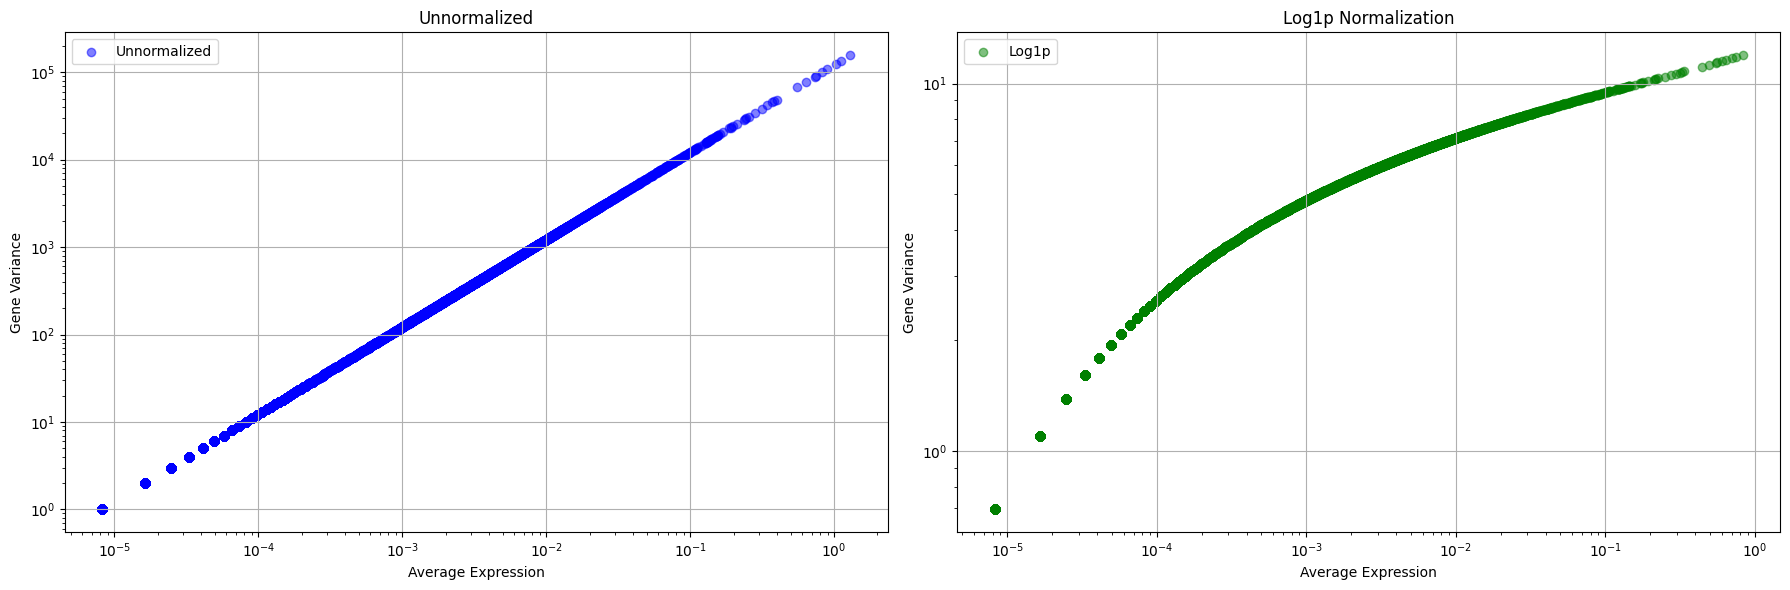

In [64]:
#Second Sample: 88_2B_157A_49XXXXY
adata2 = sc.read_h5ad('./analyzed_data/88_2B_157A_49XXXXY_filtered.h5ad')  # Load your original data
norm_adata12 = sc.read_h5ad('./analyzed_data/88_2B_157A_49XXXXY_normalized.h5ad')  # normalized data - log1p
#norm_adata22 = sc.read_h5ad('./analyzed_data/88_1_157A_49XXXXY_sctransform.h5ad')  # Load your second normalized data

# setup
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
# calls 
plot_variance_vs_mean(adata2, 'mean_counts', 'total_counts', axs[0], 'Unnormalized', color='blue', label='Unnormalized', data_location='var')
plot_variance_vs_mean(norm_adata12, 'log1p_mean_counts', 'log1p_total_counts', axs[1], 'Log1p Normalization', color='green', label='Log1p', data_location='var')
#plot_variance_vs_mean(norm_adata2, 'log_umi_sct', 'log_gene_sct', axs[2], 'SCTransform Normalization', color='red', label='SCTransform', data_location='obs')

plt.tight_layout()
plt.show()

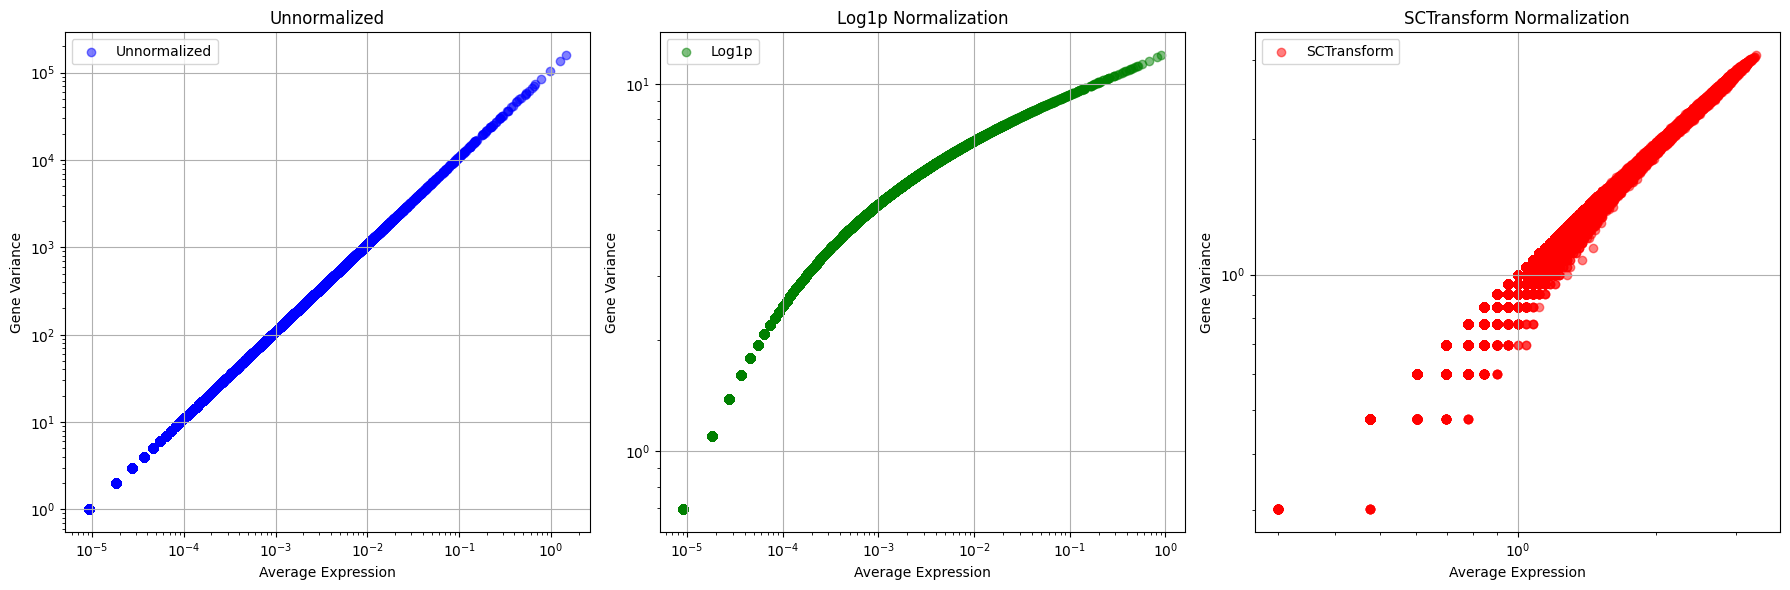

In [65]:
#third Sample: 88_3_807G_46XY
adata3 = sc.read_h5ad('./analyzed_data/88_3_807G_46XY_filtered.h5ad')  # Load your original data
norm_adata13 = sc.read_h5ad('./analyzed_data/88_3_807G_46XY_normalized.h5ad')  # normalized data - log1p
norm_adata23 = sc.read_h5ad('./analyzed_data/88_3_807G_46XY_sctransform.h5ad')  # Load your second normalized data

# setup
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# calls 
plot_variance_vs_mean(adata3, 'mean_counts', 'total_counts', axs[0], 'Unnormalized', color='blue', label='Unnormalized', data_location='var')
plot_variance_vs_mean(norm_adata13, 'log1p_mean_counts', 'log1p_total_counts', axs[1], 'Log1p Normalization', color='green', label='Log1p', data_location='var')
plot_variance_vs_mean(norm_adata23, 'log_umi_sct', 'log_gene_sct', axs[2], 'SCTransform Normalization', color='red', label='SCTransform', data_location='obs')

plt.tight_layout()
plt.show()

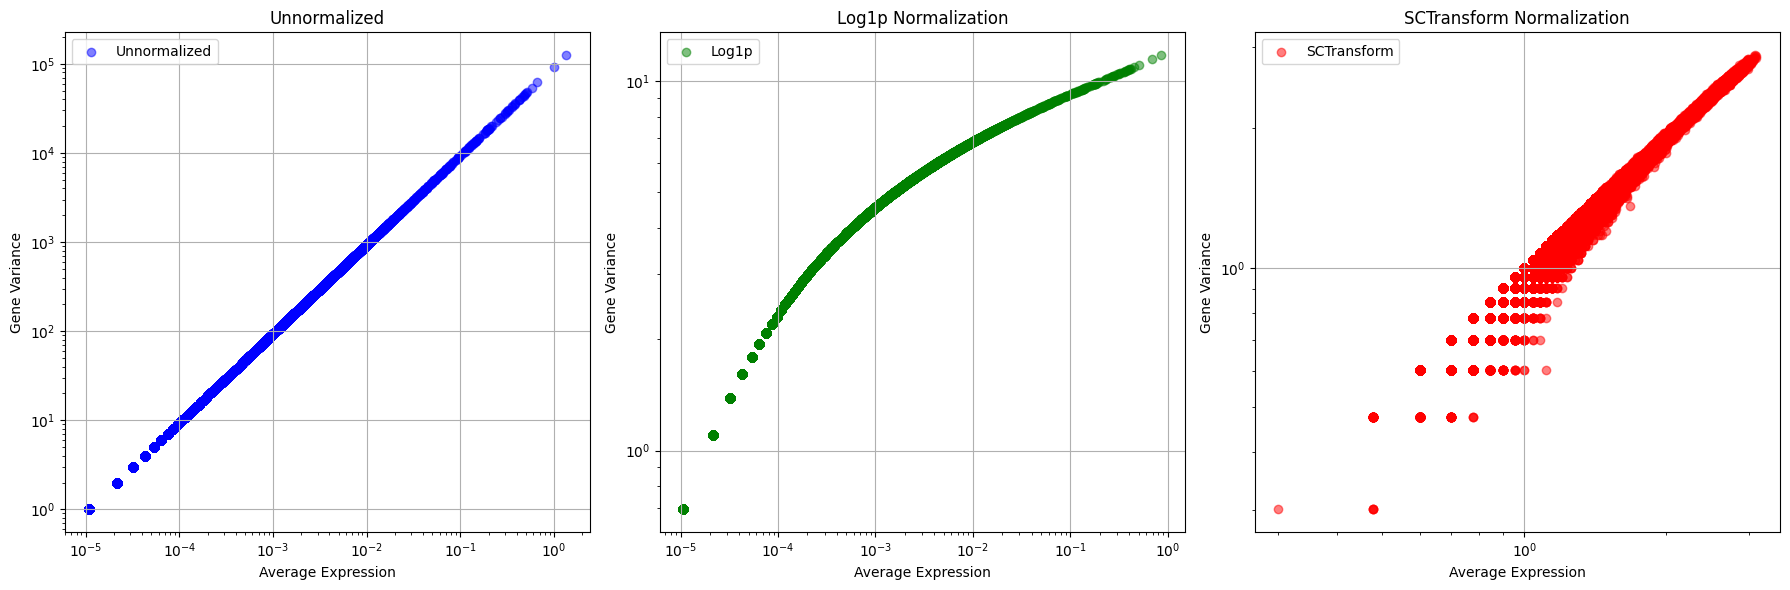

In [66]:
#fourth Sample: 88_4B_807G_46XY
adata4 = sc.read_h5ad('./analyzed_data/88_4B_807G_46XY_filtered.h5ad')  # Load your original data
norm_adata14 = sc.read_h5ad('./analyzed_data/88_4B_807G_46XY_normalized.h5ad')  # normalized data - log1p
norm_adata24 = sc.read_h5ad('./analyzed_data/88_4B_807G_46XY_sctransform.h5ad')  # Load your second normalized data

# setup
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# calls 
plot_variance_vs_mean(adata4, 'mean_counts', 'total_counts', axs[0], 'Unnormalized', color='blue', label='Unnormalized', data_location='var')
plot_variance_vs_mean(norm_adata14, 'log1p_mean_counts', 'log1p_total_counts', axs[1], 'Log1p Normalization', color='green', label='Log1p', data_location='var')
plot_variance_vs_mean(norm_adata24, 'log_umi_sct', 'log_gene_sct', axs[2], 'SCTransform Normalization', color='red', label='SCTransform', data_location='obs')

plt.tight_layout()
plt.show()

From the previous plots we can conclucude: 

*Unnormalized Data (Blue):* The variance increases exponentially with the increase in mean expression. This is a typical characteristic of raw count data, where higher expressed genes have disproportionately higher variance.Such data often require normalization because the high variance of highly expressed genes can dominate downstream analyses.

*Log1p Normalization (Green):* The Log1p normalization seems to have moderated the variance across different levels of gene expression, which is evident from the less steep increase compared to the unnormalized data.The relationship between mean and variance remains nonlinear but is noticeably less extreme. This transformation is usually beneficial because it stabilizes the variance, making data more compatible with linear models that assume constant variance.

*SCTransform Normalization (Red):* SCTransform shows a pattern where lower expressed genes have a wide spread variance, which narrows dramatically as gene expression increases.This is  effective for adjusting the technical noise and biological variance effectively, often improving the sensitivity and specificity of detecting differential expression.

**Normalization selected for Downstream analysis:** 

for this academic excercise our decision is just heuristics, Log1p might is sufficient for exploratory analysis where extreme technical effects are not a concern. But in a real research, the normalization should be considered carefully and methods that accounts for the spatial covariate should be priorized. In addition, form this point, the analysis are show only in one sample, this for practicity at the moment to compare the results with Xenium technology. 

**Detecting Highly variable genes**

Now, we detect highly variable genes. Any of the flavor(s) are designed with single-cell data in mind, so the list of highly variable genes that they select will be likely affected by the spatial autocorrelation structure. Alternative strategies could be selecting these genes based on the spatial variable genes (e.g., by Moran's I value).


In [68]:
#First sample: 88_1_157A_49XXXXY
sc.pp.highly_variable_genes(norm_adata1 , flavor="seurat", n_top_genes=2000) #norm_adata1 is './analyzed_data/88_1_157A_49XXXXY_normalized.h5ad'
#Second Sample: 88_2B_157A_49XXXXY
sc.pp.highly_variable_genes(norm_adata12 , flavor="seurat", n_top_genes=2000) #norm_adata12 is './analyzed_data/88_2B_157A_49XXXXY_normalized.h5ad'
#third Sample: 88_3_807G_46XY
sc.pp.highly_variable_genes(norm_adata13 , flavor="seurat", n_top_genes=2000) #norm_adata13 is './analyzed_data/88_3_807G_46XY_normalized.h5ad'
#fourth Sample: 88_4B_807G_46XY
sc.pp.highly_variable_genes(norm_adata14 , flavor="seurat", n_top_genes=2000) #norm_adata14 is './analyzed_data/88_4B_807G_46XY_normalized.h5ad'

**Dimentionality reduction and clustering**

We perform the dimensionality with PCA, and community clustering of the nearest neighbors graph using the leiden algorithm. For this exploratory analysis, we keep the default parameters.


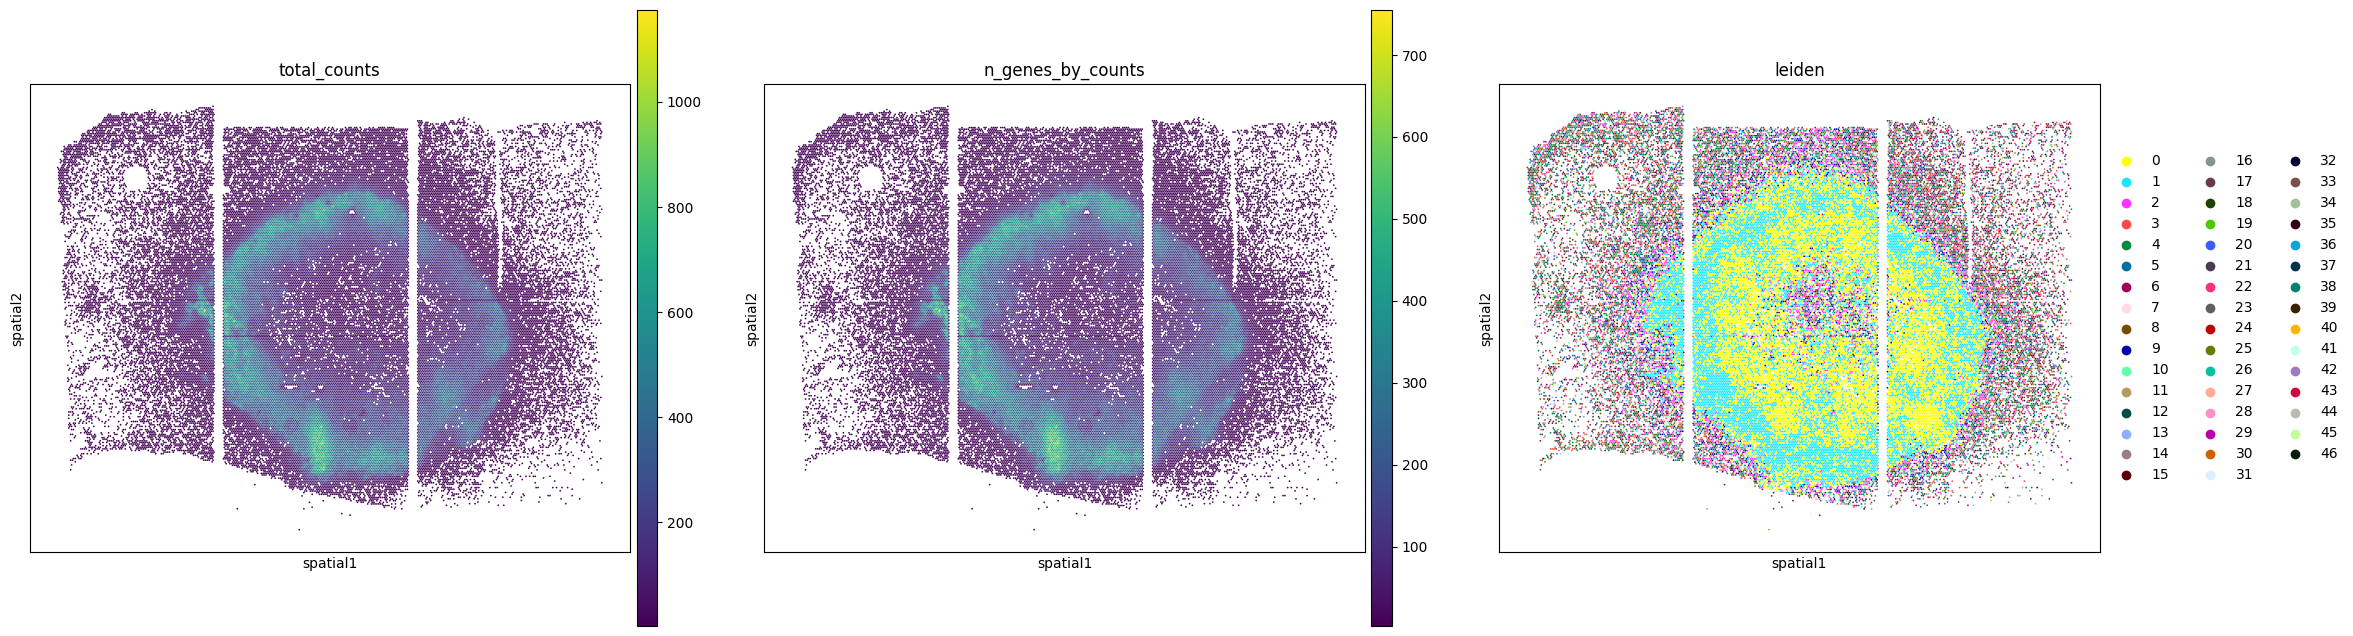

In [143]:
#First sample: 88_1_157A_49XXXXY
sc.pp.pca(norm_adata1)
sc.pp.neighbors(norm_adata1)
sc.tl.leiden(norm_adata1, resolution = 0.9, key_added="leiden")
#plots
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(norm_adata1, img_key=None, color=["total_counts", "n_genes_by_counts", "leiden"], spot_size=300)

Notice how we didn't compute the typical UMAP. It might be useful in single cell data, but it does not mean much in this kind of spatial data. Basically, since the data per cell is not normalized using an appropriate method taking into account the spatial autocorrelation, the neighborhood graph might have bias depending on the local environment. Thus, UMAP amplifies this fact and leaves a visualization that is a mere picture of the physical 2d 'neighborhood' topology of the cells, rather than representing the local/global distances in transcriptomic space.

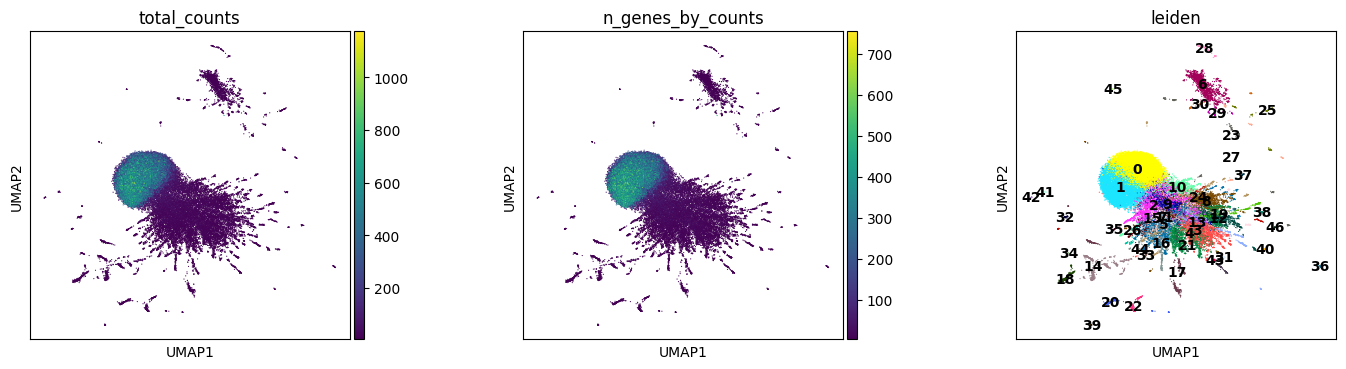

In [144]:
sc.tl.umap(norm_adata1)
plt.rcParams["figure.figsize"] = (4, 4)

sc.pl.umap(norm_adata1, color=["total_counts", "n_genes_by_counts", "leiden"], wspace=0.4, legend_loc = "on data")

**Marker Genes Detection**

A better way (compared to UMAP) of showing the pairwise relations of clusters and their transcriptomic identities is to use feature plots like dotplots or matrixplots showing the expression of significant markers of the inferred clusters, sorted following their dendrogram.


/Users/cardonky/miniconda3/envs/spatial_local/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/Users/cardonky/miniconda3/envs/spatial_local/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/Users/cardonky/miniconda3/envs/spatial_local/lib/python3.12/site-packages/scanpy/tools/_

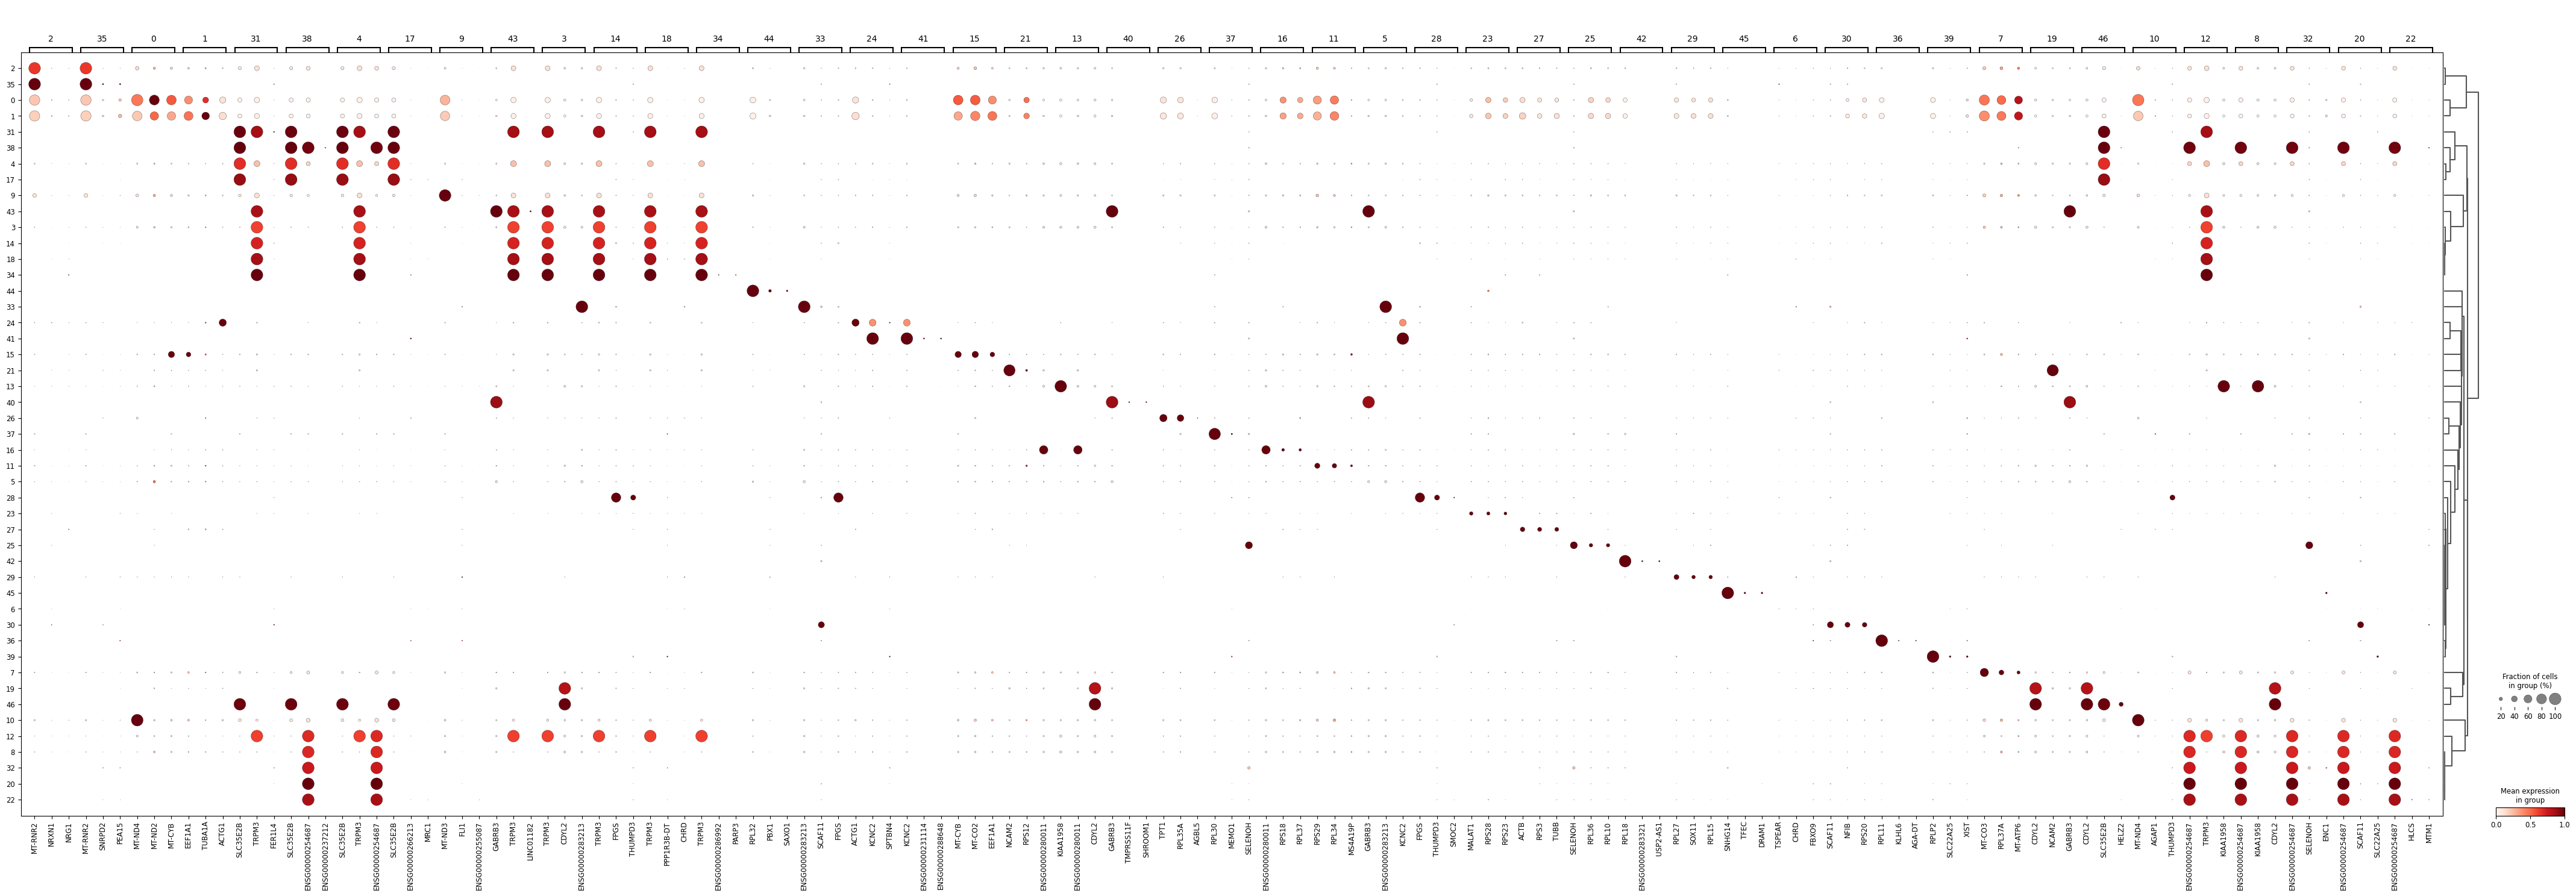

In [145]:
sc.tl.rank_genes_groups(norm_adata1, 'leiden')
sc.tl.dendrogram(norm_adata1, 'leiden')
sc.pl.rank_genes_groups_dotplot(norm_adata1, n_genes=3, standard_scale='var', min_logfoldchange=1)

For instance, in the plot above we can observe that MT-ND4 is a significant marker of cluster 10.

**Differential expression Analysis**

Form the clustering and UMAP we can indentify two major clusters in our dataset: Cluster 0 and Cluster 1. So lets perform a differential expression analysis among those clusters to pinpoint genes differentialy expressed among this cell clusters. Performing differential expression analysis between clusters in this spatial transcriptomics data using Scanpy can be done effectively with the rank_genes_groups function, which is analogous to the differential expression analysis methods used in Seurat, like the Wilcoxon rank-sum test.

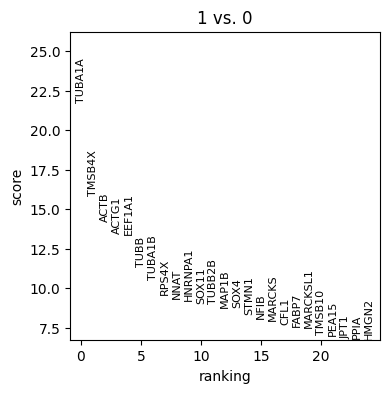

In [189]:
sc.tl.rank_genes_groups(norm_adata1, groupby='leiden', groups=['1'], reference='0', method='wilcoxon') #This compares cluster 1 against cluster 0 specifically.
# Visualize the results
sc.pl.rank_genes_groups(norm_adata1, n_genes=25, sharey=False)  # Show the top 25 genes


The plot above represent the results from the differential expression analysis between clusters 1 and 0, illustrating the top differentially expressed genes ranked by their scores from the Wilcoxon rank-sum test performed by Scanpy's. Higher scores could indicate stronger evidence of differential expression.

In [191]:
de_results = pd.DataFrame({
    'genes': norm_adata1.uns['rank_genes_groups']['names']['1'],
    'scores': norm_adata1.uns['rank_genes_groups']['scores']['1'],
    'logfoldchanges': norm_adata1.uns['rank_genes_groups']['logfoldchanges']['1'],
    'pvals': norm_adata1.uns['rank_genes_groups']['pvals']['1'],
    'pvals_adj': norm_adata1.uns['rank_genes_groups']['pvals_adj']['1']
})

# Display the top results to check
print(de_results.head(20))


       genes     scores  logfoldchanges          pvals      pvals_adj
0     TUBA1A  21.727377        0.601718  1.130791e-104  4.089366e-101
1     TMSB4X  15.876027        0.425415   9.287814e-57   2.442780e-53
2       ACTB  14.240310        0.398806   5.149814e-46   1.146071e-42
3      ACTG1  13.436791        0.325942   3.680521e-41   7.605796e-38
4     EEF1A1  13.403380        0.294850   5.777065e-41   1.114242e-37
5       TUBB  11.357276        0.351449   6.823965e-30   1.233901e-26
6     TUBA1B  10.562252        0.412114   4.458357e-26   7.587337e-23
7      RPS4X   9.624016        0.210342   6.330982e-22   9.640086e-19
8       NNAT   9.349890        0.313699   8.773950e-21   1.269196e-17
9    HNRNPA1   9.222248        0.252123   2.909353e-20   4.008118e-17
10     SOX11   9.055107        0.274824   1.364344e-19   1.794174e-16
11    TUBB2B   9.041449        0.284638   1.546087e-19   1.944776e-16
12     MAP1B   8.770175        0.283177   1.783886e-18   2.150401e-15
13      SOX4   8.763

To extract significantly differentially expressed genes from the results, we decided to filter based on adjusted p-values (to control for multiple hypothesis testing). The treshold we have set is p_adjust < 0.05

In [241]:
#filter significant genes based on p-value 
significant_genes = de_results[(de_results['pvals_adj'] < 0.05)]

# Display the filtered significant genes
print(significant_genes)

#saving in excel
significant_genes.to_excel('./analyzed_data/DEGs_1vs0_88_1_157A_49XXXXY.xlsx', index=False)

#saving aS pickle
significant_genes.to_pickle('./analyzed_data/DEGs_1vs0_88_1_157A_49XXXXY.pkl')

        genes     scores  logfoldchanges          pvals      pvals_adj
0      TUBA1A  21.727377        0.601718  1.130791e-104  4.089366e-101
1      TMSB4X  15.876027        0.425415   9.287814e-57   2.442780e-53
2        ACTB  14.240310        0.398806   5.149814e-46   1.146071e-42
3       ACTG1  13.436791        0.325942   3.680521e-41   7.605796e-38
4      EEF1A1  13.403380        0.294850   5.777065e-41   1.114242e-37
...       ...        ...             ...            ...            ...
28926  MT-CO2 -24.203024       -0.469664  2.067430e-129  1.196256e-125
28927  MT-ND3 -24.688467       -0.489310  1.422531e-134  1.028881e-130
28928  MT-CYB -40.484631       -0.928975   0.000000e+00   0.000000e+00
28929  MT-ND2 -50.363777       -1.110171   0.000000e+00   0.000000e+00
28930  MT-ND4 -92.323624       -1.444275   0.000000e+00   0.000000e+00

[132 rows x 5 columns]


**Visualization**

We can visualize the expression of specific markers over the spatial dimension or on the UMAP coordinates.

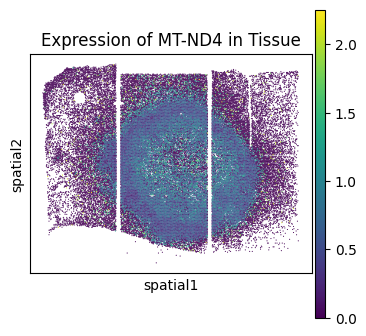

In [211]:
sc.pl.spatial(norm_adata1, color='MT-ND4', spot_size=400, title='Expression of MT-ND4 in Tissue')

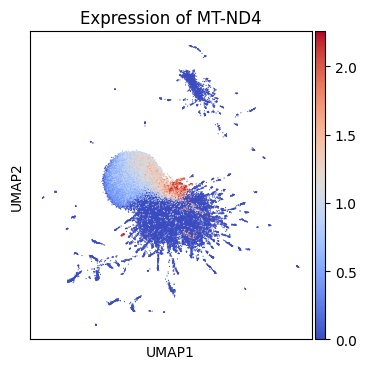

In [209]:
# EXAMPLE in one down regulated 
sc.pl.umap(norm_adata1, color=['MT-ND4'], show=True, title='Expression of MT-ND4', use_raw=False, cmap='coolwarm')

In [239]:
#saving the last object
norm_adata1.write(f'./analyzed_data/88_1_157a_49XXXXY_final_object.h5ad')

**Next Steps on Analysis**

For the term of this academic excersice we are going to perform the analysis until this point, however to fully understand the impact and significance of the difference in expression between these clusters we could perform additional analysis such as: pathaways and functional annotation with gene ontology terms (ORA,GSEA etc), co-expression networks,developmental trajectories (specially usefull for datasets like the one analyzed here, where cell s are undergoing development), mutiomics integrations, such as genomics, proteomics or metabolomicas to gain a multi-layer unterstanding of the tissue state, cell to cell interaction analysis etc.

**REFERENCES**

Schott, M., León-Periñán, D., Splendiani, E., Strenger, L., Licha, J. R., Pentimalli, T. M., ... & Rajewsky, N. (2023). Open-ST: High-resolution spatial transcriptomics in 3D. bioRxiv, 2023-12.


